In [1]:
import torch
import torch.nn as nn
import os
import cv2
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
from torchvision import models
from torchvision import transforms
import os

In [3]:
if(os.path.split(os.getcwd())[1] == "Transfer_Learning" or os.path.split(os.getcwd())[1] == "semi-supervised" or os.path.split(os.getcwd())[1] == "self-supervised"):
    os.chdir("..")
print("Current Working Directory: {}".format(os.path.split(os.getcwd())[1]))

Current Working Directory: progettoVIPM


In [4]:
cuda=True

In [5]:
from utils.loadersAndEnums import datasets, ImageDataset
from torch.utils.data import DataLoader, ConcatDataset, random_split


trainL = ImageDataset(dataset=datasets.TRAINING_LABELED_80,network_input_size=256,cuda=cuda)
validation = ImageDataset(dataset=datasets.VALIDATION_LABELED_20,network_input_size=256,cuda=cuda)

In [6]:
trainL = DataLoader(trainL,128,shuffle=False)
validation = DataLoader(validation, shuffle=False)

In [9]:
feature_train = np.load("self-supervised/features/featureEncoderLabledTrainingSet80.npy")
feature_val = np.load("self-supervised/features/featureEncoderLabledValidationSet20.npy")

In [10]:
labelsTrain = []
for input,labels in trainL:
    labelsTrain.extend(labels.numpy())

In [11]:
labelsVal = []
for input, labels in validation:
    labelsVal.extend(labels.numpy())

 14%|█▍        | 1/7 [13:30<1:21:05, 810.95s/it]

Linear Support Vector obtained following accuracy: 0.018924302788844622


 29%|██▊       | 2/7 [23:22<56:49, 681.99s/it]  

Rbf Support Vector obtained following accuracy: 0.0199203187250996


 43%|████▎     | 3/7 [24:17<26:23, 395.76s/it]

KNN with 1 neighbors obtained following accuracy: 0.01195219123505976


 57%|█████▋    | 4/7 [25:11<13:01, 260.60s/it]

KNN with 10 neighbors obtained following accuracy: 0.012948207171314742


 71%|███████▏  | 5/7 [26:01<06:09, 184.92s/it]

KNN with 20 neighbors obtained following accuracy: 0.010956175298804782


 86%|████████▌ | 6/7 [26:56<02:20, 140.46s/it]

KNN with 50 neighbors obtained following accuracy: 0.008964143426294821


100%|██████████| 7/7 [28:34<00:00, 244.88s/it]

Naive Bayes obtained following accuracy: 0.00597609561752988


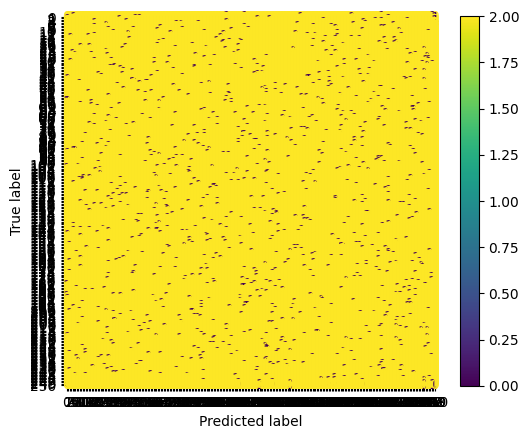

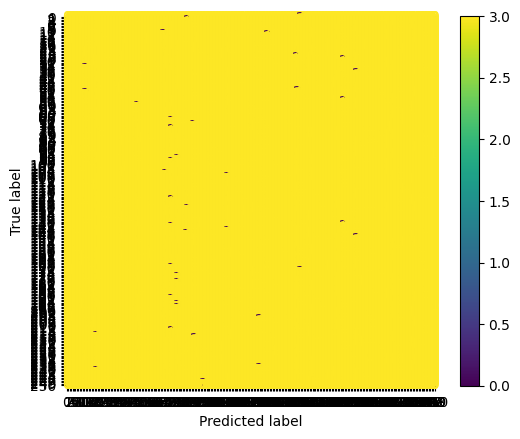

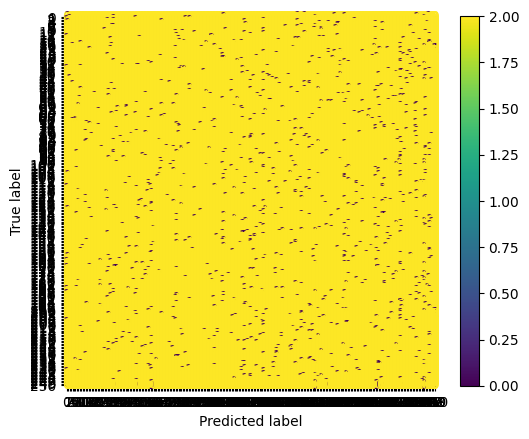

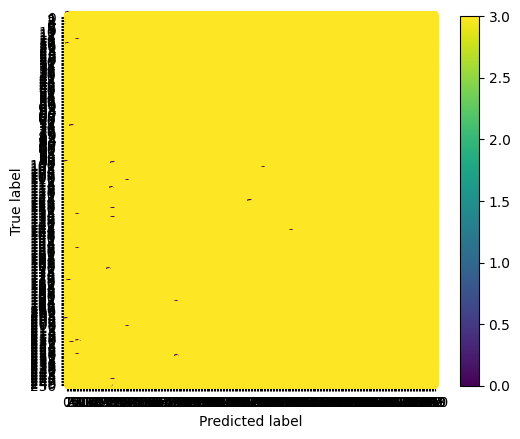

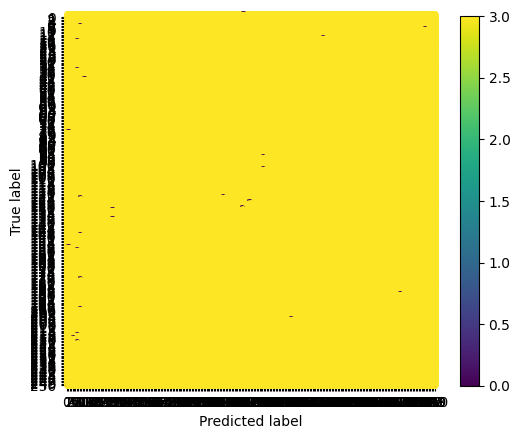

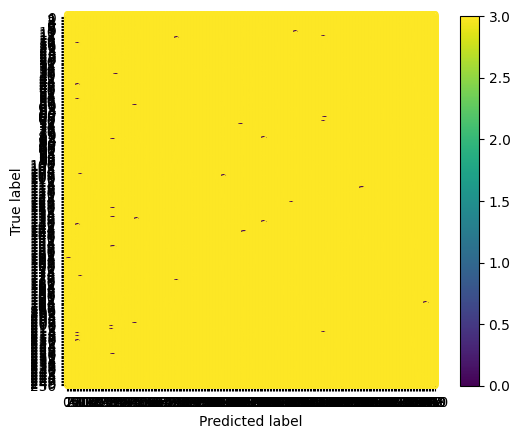

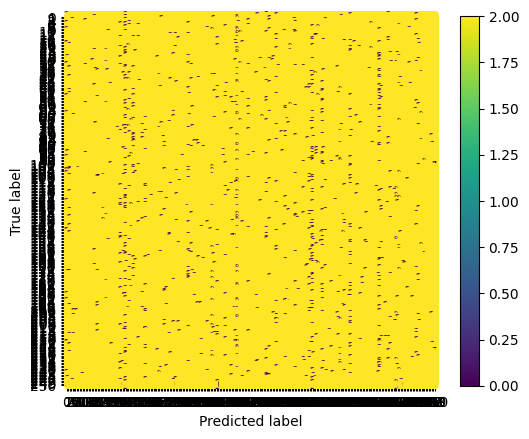

In [13]:
from enum import Enum
import pickle

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix


class ml_models(Enum):
    LINEAR_SVC = [LinearSVC(), "Linear Support Vector"]
    RBF_SVC = [SVC(kernel="rbf"), "Rbf Support Vector"]
    # RANDOM_FOREST = [RandomForestClassifier(), "Random Forest"]
    # BOOSTED_FOREST = [GradientBoostingClassifier(), "Gradient Boosting Classifier"]
    KNN_1 = [KNeighborsClassifier(n_neighbors=1), "KNN with 1 neighbors"]
    KNN_10 = [KNeighborsClassifier(n_neighbors=10), "KNN with 10 neighbors"]
    KNN_20 = [KNeighborsClassifier(n_neighbors=20), "KNN with 20 neighbors"]
    KNN_50 = [KNeighborsClassifier(n_neighbors=50), "KNN with 50 neighbors"]
    NAIVE_BAYES = [GaussianNB(), "Naive Bayes"]
    
def model_building(model, model_name, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc=accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
    disp.plot()
    plt.savefig("./self-supervised/model_metrics/ConfM_{}.pdf".format(model_name))
    cm = np.array(cm)
    np.save("./self-supervised/model_metrics/ConfM_{}.npy".format(model_name), cm)
    with open('./self-supervised/models/{}.pkl'.format(model_name),'wb') as f:
        pickle.dump(model,f)
    return acc
    

is_pca_used = False

x_train = feature_train
x_test = feature_val

model_accuracies = []
for model in tqdm(ml_models):    
    model_name = "{}_from_{}_minus{}".format(model.value[1], "EncoderV2", 1)
    if is_pca_used:
        model_name += "_pca"
    score = model_building(model.value[0], model_name, x_train, x_test, labelsTrain, labelsVal)
    print("{} obtained following accuracy: {}".format(model.value[1],score))
    model_accuracies.append([model_name, score])
model_accuracies = np.array(model_accuracies)
accuracies_filename = "./self-supervised/model_metrics/Accuracies_{}_minus{}".format("EncoderV2", 1)
if is_pca_used:
    accuracies_filename += "_pca"
np.save("{}.npy".format(accuracies_filename), model_accuracies)